## LeNet-5 (MNIST)

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define the LeNet-5 architecture
# class LeNet5(nn.Module):
#     def __init__(self, in_channels=1, num_classes=10):
#         super(LeNet5, self).__init__()
#         self.num_classes = num_classes
#         self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Convolutional layer with 6 feature maps of size 5x5
#         self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 6 feature maps of size 2x2
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Convolutional layer with 16 feature maps of size 5x5
#         self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 16 feature maps of size 2x2
        
#         # These layers depend on the input size
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully connected layer, output size 120
#         self.fc2 = nn.Linear(120, 84)  # Fully connected layer, output size 84
#         self.fc3 = nn.Linear(84, num_classes)  # Fully connected layer, output size num_classes

#     def forward(self, x):
#         x = F.relu(self.conv1(x))  # Apply ReLU after conv1
#         x = self.pool1(x)  # Apply subsampling pool1
#         x = F.relu(self.conv2(x))  # Apply ReLU after conv2
#         x = self.pool2(x)  # Apply subsampling pool2
#         x = x.view(x.size(0), -1)  # Flatten for fully connected layers
#         x = F.relu(self.fc1(x))  # Apply ReLU after fc1
#         x = F.relu(self.fc2(x))  # Apply ReLU after fc2
#         x = self.fc3(x)  # Output layer
#         return x

# Define a function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % 100 == 0:
        #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
        #           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Define a function to test the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    latent_all = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, latent = model(data, latent=True)
            latent_all.append(latent.cpu().numpy())
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')
    
    latent_all = np.concatenate(latent_all, axis=0)
    latent_mean = np.mean(latent_all, axis=0)
    print(f"Latent Mean: {np.mean(latent_mean)}, Latent Std: {np.std(latent_mean)}, Latent Max: {np.max(latent_mean)}, Latent Min: {np.min(latent_mean)}")
    
    
    
# define device
def check_gpu(manual_seed=True, print_info=True):
    if manual_seed:
        torch.manual_seed(0)
    if torch.cuda.is_available():
        if print_info:
            print("CUDA is available")
        device = 'cuda'
        torch.cuda.manual_seed_all(0) 
    elif torch.backends.mps.is_available():
        if print_info:
            print("MPS is available")
        device = torch.device("mps")
        torch.mps.manual_seed(0)
    else:
        if print_info:
            print("CUDA is not available")
        device = 'cpu'
    return device

# Main function to run the training and testing
def main():
    # Training settings
    batch_size = 128
    test_batch_size = 1000
    epochs = 100
    lr = 0.01
    momentum = 0.9
    no_cuda = False
    seed = 1

    device = check_gpu(manual_seed=True, print_info=True)

    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    # reduce the dimension of training data
    train_dataset.data = train_dataset.data[:5000]
    test_dataset = datasets.MNIST('../data', train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    model = LeNet5(in_channels=1, num_classes=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

if __name__ == '__main__':
    main()

MPS is available


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [132]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [133]:
from sklearn.decomposition import PCA

 
# Training settings
batch_size = 64
test_batch_size = 1000
epochs = 100
lr = 0.01
momentum = 0.9
no_cuda = False
seed = 1

device = check_gpu(manual_seed=True, print_info=True)

torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
# take the first 1000 samples
train_dataset.data = train_dataset.data[:2000]
test_dataset = datasets.MNIST('../data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Define the LeNet-5 architecture
# LeNet-5 model
from math import prod
class LeNet5(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, input_size=(28, 28)):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Convolutional layer with 6 feature maps of size 5x5
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 6 feature maps of size 2x2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Convolutional layer with 16 feature maps of size 5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 16 feature maps of size 2x2
        
        # Dinamically calculate the size of the features after convolutional layers
        dummy_input = torch.zeros(1, in_channels, *input_size)
        dummy_output = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        self.feature_size = prod(dummy_output.size()[1:])

        self.fc1 = nn.Linear(self.feature_size, 120)  # Fully connected layer, output size 120
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer, output size 84
        self.fc3 = nn.Linear(84, num_classes)  # Fully connected layer, output size num_classes

    def forward(self, x, latent=False):
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(x)  # Apply subsampling pool1
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(x)  # Apply subsampling pool2
        x_l = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x_l))  # Apply ReLU after fc1
        x = F.relu(self.fc2(x))  # Apply ReLU after fc2
        x = self.fc3(x)  # Output layer
        if latent:
            return x, x_l
        else:
            return x

# LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, input_size=(28, 28)):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Convolutional layer with 6 feature maps of size 5x5
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 6 feature maps of size 2x2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Convolutional layer with 16 feature maps of size 5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 16 feature maps of size 2x2
        
        # Dinamically calculate the size of the features after convolutional layers
        dummy_input = torch.zeros(1, in_channels, *input_size)
        dummy_output = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        self.feature_size = prod(dummy_output.size()[1:])

        self.fc1 = nn.Linear(self.feature_size, 120)  # Fully connected layer, output size 120
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer, output size 84
        self.fc3 = nn.Linear(84, num_classes)  # Fully connected layer, output size num_classes

    def forward(self, x, latent=False):
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(x)  # Apply subsampling pool1
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(x)  # Apply subsampling pool2
        x_l = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x_l))  # Apply ReLU after fc1
        x = F.relu(self.fc2(x))  # Apply ReLU after fc2
        x = self.fc3(x)  # Output layer
        if latent:
            return x, x_l
        else:
            return x
    

# Resnet-9 layer
def residual_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


# ResNet-9 model
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes, input_size=(28, 28)):
        super().__init__()
        self.num_classes = num_classes
        self.prep = residual_block(in_channels, 64)
        self.layer1_head = residual_block(64, 128, pool=True)
        self.layer1_residual = nn.Sequential(residual_block(128, 128), residual_block(128, 128))
        self.layer2 = residual_block(128, 256, pool=True)
        self.layer3_head = residual_block(256, 512, pool=True)
        self.layer3_residual = nn.Sequential(residual_block(512, 512), residual_block(512, 512))
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Changed to adaptive average pooling:         self.MaxPool2d = nn.Sequential(nn.MaxPool2d(4))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the features after the convolutional layers
        dummy_input = torch.zeros(1, in_channels, *input_size)
        dummy_output = self.pool(self.layer3_head(self.layer2(self.layer1_head(self.prep(dummy_input)))))
        self.feature_size = dummy_output.size(1) * dummy_output.size(2) * dummy_output.size(3)

        # Output layer
        self.linear = nn.Linear(self.feature_size, num_classes)

    def forward(self, x, latent=False):
        x = self.prep(x)
        x = self.layer1_head(x)
        x = self.layer1_residual(x) + x
        x = self.layer2(x)
        x = self.layer3_head(x)
        x = self.layer3_residual(x) + x
        x = self.pool(x)  # Changed to adaptive average pooling
        x_l = x.view(x.size(0), -1)
        x = self.linear(x_l)
        if latent:
            return x, x_l
        else:
            return x
    

model = ResNet9(in_channels=1, num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


MPS is available

Test set: Average loss: 0.6712, Accuracy: 7651/10000 (77%)

Latent Mean: 1.3499350547790527, Latent Std: 0.9161264300346375, Latent Max: 8.477176666259766, Latent Min: 0.08574561774730682

Test set: Average loss: 0.2537, Accuracy: 9252/10000 (93%)

Latent Mean: 0.972943902015686, Latent Std: 0.4720045030117035, Latent Max: 3.5702555179595947, Latent Min: 0.057498980313539505

Test set: Average loss: 0.1920, Accuracy: 9399/10000 (94%)

Latent Mean: 1.0231431722640991, Latent Std: 0.5263200402259827, Latent Max: 4.648538112640381, Latent Min: 0.052269477397203445

Test set: Average loss: 0.1836, Accuracy: 9430/10000 (94%)

Latent Mean: 0.9468675851821899, Latent Std: 0.45056429505348206, Latent Max: 3.0544557571411133, Latent Min: 0.05543508753180504

Test set: Average loss: 0.1670, Accuracy: 9477/10000 (95%)

Latent Mean: 0.9960904121398926, Latent Std: 0.4929356276988983, Latent Max: 3.220304012298584, Latent Min: 0.05475081875920296

Test set: Average loss: 0.1155, A

KeyboardInterrupt: 

In [135]:
# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

# ModelEvaluator class
class ModelEvaluator:
    def __init__(self, test_loader, device):
        """
        Initializes the ModelEvaluator with the model, device, and number of classes.
        
        Args:
            test_loader: DataLoader with test data
            device: Device to run the evaluation on
        """
        
        self.test_loader = test_loader
        self.device = device
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
        self.criterion_trad = torch.nn.CrossEntropyLoss() 
        

    def evaluate(self, model, latent=False, max_latent_space=None):
        """
        Evaluates the model on the provided test data and returns various metrics.

        Args:
            model: Model to evaluate
            latent: Whether to return the latent representation of the test data
        """
        
        # client-enhanced evaluation function
        # def evaluate_model_per_class(model, device, test_loader, latent=False):
        # Set model to evaluation mode
        model.eval()
        num_classes = model.num_classes

        # Initialize storage for metrics
        precision_per_class = [0] * num_classes
        recall_per_class = [0] * num_classes
        f1_per_class = [0] * num_classes
        accuracy_per_class = [0] * num_classes
        loss_per_class = [0] * num_classes
        class_counts = [0] * num_classes

        y_true_all = []
        y_pred_all = []
        loss_all = []
        latent_all = []
        latent_mean = []
        loss_trad = 0
        total_samples = 0

        # Accumulate predictions and targets over batches
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Get model predictions
                if latent: 
                    output, latent_space = model(data, latent=True)
                    latent_all.extend(latent_space.cpu().numpy())
                else: 
                    output = model(data) 
                    
                y_pred_batch = output.argmax(dim=1, keepdim=False)  # Predicted class labels
                
                # Store the true and predicted labels for the batch
                y_true_all.extend(target.cpu().numpy())
                y_pred_all.extend(y_pred_batch.cpu().numpy())
                
                # Compute per-sample loss for the batch
                batch_loss = self.criterion(output, target).cpu().numpy()
                loss_all.extend(batch_loss)
                
                # Compute traditional loss for the batch
                loss_trad += self.criterion_trad(output, target).item()
                
                # Accumulate the total number of samples
                total_samples += len(target)

        # Convert collected predictions and true labels into tensors for processing
        y_true_all = torch.tensor(y_true_all)
        y_pred_all = torch.tensor(y_pred_all)
        loss_all = torch.tensor(loss_all)
        
        # Average traditional loss over the total number of samples
        loss_trad /= total_samples
        
        # Calculate traditional accuracy on the entire test set
        accuracy_trad = accuracy_score(y_true_all, y_pred_all)
        
        # Average latent
        if latent:
            latent_all = np.array(latent_all)
            print(f"Shape of latent_all before PCA: {latent_all.shape}")
            # SCALE OR NOT TRY BOTH
            # scaler = MinMaxScaler(feature_range=(0, max_latent_space)) # maybe try also StandardScaler
            # latent_all = scaler.fit_transform(latent_all) # Sample, Dim_latent_space
            # print(f"Min-Max values of latent_all: {np.min(latent_all)}, {np.max(latent_all)}")
            # create random_points to fit PCA (min=0, max=max_latent_space)
            np.random.seed(seed=1)
            random_points = np.random.uniform(0, max_latent_space+2, size=(200, latent_all.shape[1]))
            pca = PCA(n_components=num_classes)
            # fit PCA on random_points
            pca.fit(random_points)
            # transform latent_all
            latent_all = pca.transform(latent_all)
            print(f"Shape of latent_all after PCA: {latent_all.shape}")
            # Mean on first dimension
            latent_mean = np.mean(latent_all, axis=0)
            print(f"shape of latent_mean: {latent_mean.shape}")
            
        # Iterate through each class (for MNIST, classes are 0 to 9 by default)
        for class_idx in range(num_classes):
            # Get all predictions and ground truths for the current class
            class_mask = (y_true_all == class_idx)  # Mask for this class
            
            y_true_class = (y_true_all == class_idx).numpy().astype(int)  # Binary labels for the current class
            y_pred_class = (y_pred_all == class_idx).numpy().astype(int)  # Binary predictions for the current class
            
            # Only calculate if there are samples for this class
            if class_mask.sum() > 0:
                # Compute precision, recall, and F1-score for this class
                precision = precision_score(y_true_class, y_pred_class, zero_division=0)
                recall = recall_score(y_true_class, y_pred_class, zero_division=0)
                f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
                accuracy = accuracy_score(y_true_class, y_pred_class)

                # Compute the loss for this class (average the loss of samples in this class)
                class_loss = loss_all[class_mask].mean().item()

                # Update class counts and metrics
                precision_per_class[class_idx] = precision
                recall_per_class[class_idx] = recall
                f1_per_class[class_idx] = f1
                accuracy_per_class[class_idx] = accuracy
                loss_per_class[class_idx] = class_loss
                class_counts[class_idx] = class_mask.sum().item()

        return loss_trad, accuracy_trad, precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class, latent_mean


In [124]:
model = ResNet9(in_channels=1, num_classes=10).to(device)
evaluator = ModelEvaluator(test_loader, device)
loss_trad, accuracy_trad, precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class, latent_all = evaluator.evaluate(model, latent=True, max_latent_space=2)
print(f"Traditional Loss: {loss_trad}, Traditional Accuracy: {accuracy_trad}")
print(f"Precision: {precision_per_class}")
print(f"Recall: {recall_per_class}")
print(f"F1: {f1_per_class}")
print(f"Accuracy: {accuracy_per_class}")
print(f"Loss: {loss_per_class}")
print(f"Latent Mean: {np.mean(latent_all)}, Latent Std: {np.std(latent_all)}, Latent Max: {np.max(latent_all)}, Latent Min: {np.min(latent_all)}")

Shape of latent_all before PCA: (10000, 512)
Min-Max values of latent_all: 0.0, 2.000000238418579
Shape of latent_all after PCA: (10000, 10)
shape of latent_mean: (10,)
Traditional Loss: 0.0023003185749053954, Traditional Accuracy: 0.14
Precision: [0.0, 0.13983739837398373, 0.0, 0.19558011049723756, 0.0, 0.0, 0.3333333333333333, 0.058823529411764705, 0.0, 0.10477299185098952]
Recall: [0.0, 0.9850220264317181, 0.0, 0.17524752475247524, 0.0, 0.0, 0.0010438413361169101, 0.013618677042801557, 0.0, 0.08919722497522299]
F1: [0.0, 0.24490690032858708, 0.0, 0.18485639686684074, 0.0, 0.0, 0.002081165452653486, 0.022116903633491312, 0.0, 0.09635974304068523]
Accuracy: [0.902, 0.3106, 0.8968, 0.8439, 0.9018, 0.9108, 0.9041, 0.8762, 0.9026, 0.8312]
Loss: [2.3571455478668213, 2.2325198650360107, 2.3182084560394287, 2.2502312660217285, 2.344841718673706, 2.4055612087249756, 2.2774877548217773, 2.2644283771514893, 2.3214900493621826, 2.254664659500122]
Latent Mean: 0.013517613615449448, Latent Std: 0

In [137]:
list(latent_all)

[-0.16221555372172541,
 0.19649889612940588,
 0.14639664684456435,
 0.6107625107736734,
 -0.3436018100599132,
 0.17317741542740847,
 0.535733507743075,
 0.02791765854889959,
 -0.6021221324248819,
 -0.4473710031060118]

In [78]:
# if client list not define, print
if not 'client_list' in locals():
    print("No client CID provided. Skipping the submission.")

No client CID provided. Skipping the submission.


In [74]:
import json
json.dumps(precision_per_class)

'[0.9918533604887984, 0.9964726631393298, 0.9940711462450593, 0.9776264591439688, 0.9957850368809273, 0.9746136865342163, 0.9968051118210862, 0.9551820728291317, 0.997907949790795, 0.9696969696969697]'

In [59]:
    # standard scaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    scaler = StandardScaler()
    
    # Set model to evaluation mode
    model.eval()
    num_classes = model.num_classes
    latent = True

    # Define the cross-entropy loss function
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    criterion_trad = torch.nn.CrossEntropyLoss()

    # Initialize storage for metrics
    precision_per_class = [0] * num_classes
    recall_per_class = [0] * num_classes
    f1_per_class = [0] * num_classes
    accuracy_per_class = [0] * num_classes
    loss_per_class = [0] * num_classes
    class_counts = [0] * num_classes

    y_true_all = []
    y_pred_all = []
    loss_all = []
    latent_all = []
    loss_trad = 0
    total_samples = 0

    # Accumulate predictions and targets over batches
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model predictions
            if latent: 
                output, latent_space = model(data, latent=True)
                latent_all.extend(latent_space.cpu().numpy())
            else: 
                output = model(data) 
                
            y_pred_batch = output.argmax(dim=1, keepdim=False)  # Predicted class labels
            
            # Store the true and predicted labels for the batch
            y_true_all.extend(target.cpu().numpy())
            y_pred_all.extend(y_pred_batch.cpu().numpy())
            
            # Compute per-sample loss for the batch
            batch_loss = criterion(output, target).cpu().numpy()
            loss_all.extend(batch_loss)
            
            # Compute traditional loss for the batch
            loss_trad += criterion_trad(output, target).item()
            
            # Accumulate the total number of samples
            total_samples += len(target)

    # Convert collected predictions and true labels into tensors for processing
    y_true_all = torch.tensor(y_true_all)
    y_pred_all = torch.tensor(y_pred_all)
    loss_all = torch.tensor(loss_all)
    
    # Average traditional loss over the total number of samples
    loss_trad /= total_samples
    
    # Calculate traditional accuracy on the entire test set
    accuracy_trad = accuracy_score(y_true_all, y_pred_all)
    
    # normalize latent space
    latent_all = np.array(latent_all)
    latent_all = latent_all.mean(axis=0)
    scaler.fit(latent_all.reshape(-1, 1))
    latent_all = scaler.transform(latent_all.reshape(-1, 1))
    
    # PCA
    rand_points = torch.normal(mean=0, std=1, size=(100, latent_all.shape[1]))
    pca_model = PCA(n_components=30)
    
    # # Average latent
    # if latent:
    #     latent_all = torch.tensor(latent_all)
    #     latent_all = latent_all.view(latent_all.size(0), -1)
    #     latent_all = latent_all.mean(dim=0).numpy()

In [ ]:
        rand_points = torch.normal(mean=0, std=0.1, size=(100, errors.shape[1]))


In [58]:
latent_all.shape

(512,)

In [60]:
import numpy as np
# latent_all = np.array(latent_all)
# average latent space along the samples
# latent_all_mean = latent_all.mean(axis=0)
max(latent_all), min(latent_all), np.std(latent_all), np.mean(latent_all)

(array([5.9790297], dtype=float32),
 array([-1.2622539], dtype=float32),
 0.99999994,
 -1.8626451e-09)

In [23]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model_per_class(model, device, test_loader, num_classes=10):
    # Set model to evaluation mode
    model.eval()

    # Define the cross-entropy loss function
    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    # Initialize storage for metrics
    precision_per_class = [0] * num_classes
    recall_per_class = [0] * num_classes
    f1_per_class = [0] * num_classes
    accuracy_per_class = [0] * num_classes
    loss_per_class = [0] * num_classes
    class_counts = [0] * num_classes

    y_true_all = []
    y_pred_all = []
    loss_all = []

    # Accumulate predictions and targets over batches
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model predictions
            output = model(data)
            y_pred_batch = output.argmax(dim=1, keepdim=False)  # Predicted class labels
            
            # Store the true and predicted labels for the batch
            y_true_all.extend(target.cpu().numpy())
            y_pred_all.extend(y_pred_batch.cpu().numpy())
            
            # Compute per-sample loss for the batch
            batch_loss = criterion(output, target).cpu().numpy()
            loss_all.extend(batch_loss)

    # Convert collected predictions and true labels into tensors for processing
    y_true_all = torch.tensor(y_true_all)
    y_pred_all = torch.tensor(y_pred_all)
    loss_all = torch.tensor(loss_all)

    # Iterate through each class (for MNIST, classes are 0 to 9 by default)
    for class_idx in range(num_classes):
        # Get all predictions and ground truths for the current class
        class_mask = (y_true_all == class_idx)  # Mask for this class
        
        y_true_class = (y_true_all == class_idx).numpy().astype(int)  # Binary labels for the current class
        y_pred_class = (y_pred_all == class_idx).numpy().astype(int)  # Binary predictions for the current class
        
        # Only calculate if there are samples for this class
        if class_mask.sum() > 0:
            # Compute precision, recall, and F1-score for this class
            precision = precision_score(y_true_class, y_pred_class, zero_division=0)
            recall = recall_score(y_true_class, y_pred_class, zero_division=0)
            f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
            accuracy = accuracy_score(y_true_class, y_pred_class)

            # Compute the loss for this class (average the loss of samples in this class)
            class_loss = loss_all[class_mask].mean().item()

            # Update class counts and metrics
            precision_per_class[class_idx] = precision
            recall_per_class[class_idx] = recall
            f1_per_class[class_idx] = f1
            accuracy_per_class[class_idx] = accuracy
            loss_per_class[class_idx] = class_loss
            class_counts[class_idx] = class_mask.sum().item()

    return precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class

precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class, loss_all = evaluate_model_per_class(model, device, test_loader)
print("Class-wise evaluation:")
for class_idx in range(10):
    print(f"Class {class_idx}: Precision = {precision_per_class[class_idx]:.4f}, Recall = {recall_per_class[class_idx]:.4f}, F1 = {f1_per_class[class_idx]:.4f}, Accuracy = {accuracy_per_class[class_idx]:.4f}, Loss = {loss_per_class[class_idx]:.4f}")

Class-wise evaluation:
Class 0: Precision = 0.9797, Recall = 0.9837, F1 = 0.9817, Accuracy = 0.9964, Loss = 0.0577
Class 1: Precision = 0.9868, Recall = 0.9877, F1 = 0.9872, Accuracy = 0.9971, Loss = 0.0401
Class 2: Precision = 0.9488, Recall = 0.9874, F1 = 0.9677, Accuracy = 0.9932, Loss = 0.0427
Class 3: Precision = 0.9446, Recall = 0.9792, F1 = 0.9616, Accuracy = 0.9921, Loss = 0.0633
Class 4: Precision = 0.9747, Recall = 0.9827, F1 = 0.9787, Accuracy = 0.9958, Loss = 0.0559
Class 5: Precision = 0.9593, Recall = 0.9776, F1 = 0.9684, Accuracy = 0.9943, Loss = 0.0750
Class 6: Precision = 0.9874, Recall = 0.9781, F1 = 0.9827, Accuracy = 0.9967, Loss = 0.0676
Class 7: Precision = 0.9792, Recall = 0.9601, F1 = 0.9695, Accuracy = 0.9938, Loss = 0.1321
Class 8: Precision = 0.9788, Recall = 0.9476, F1 = 0.9630, Accuracy = 0.9929, Loss = 0.1553
Class 9: Precision = 0.9865, Recall = 0.9386, F1 = 0.9619, Accuracy = 0.9925, Loss = 0.1915


In [28]:
loss_all

tensor([1.1629e-03, 1.5663e-04, 5.1977e-03,  ..., 7.3909e-06, 3.2062e-04,
        8.0701e-05])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# client-enhanced evaluation function
def client_enhanced_evaluation(model, device, test_loader):
    model.eval()
    # with torch.no_grad():
    #     for data, target in test_loader:
    #         data, target = data.to(device), target.to(device)
    #         output = model(data)
    #         y_pred.extend(output.argmax(dim=1, keepdim=True).cpu().numpy())
    #         y_true.extend(target.cpu().numpy())
            
    # Accumulate predictions and targets
    y_pred, y_true = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.append(output.argmax(dim=1).cpu())
            y_true.append(target.cpu())

    # Convert lists to tensors
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    # Calculate the loss for each sample
    criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Set reduction='none' to get the loss per sample
    loss_per_sample = criterion(y_pred, y_true).cpu()

    # Initialize storage for metrics
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []
    accuracy_per_class = []
    loss_per_class = []

    # Iterate through each class (for MNIST, classes are 0 to 9)
    for class_idx in range(model.num_classes):
        # Get all predictions and ground truths for the current class
        class_mask = (y_true == class_idx)  # Mask for this class
        
        y_true_class = (y_true == class_idx)  # Convert to binary for the current class
        y_pred_class = (y_pred == class_idx)  # Convert to binary for the current class
        
        # Compute precision, recall, and F1-score for this class (treat as binary classification)
        precision = precision_score(y_true_class, y_pred_class, average='binary', pos_label=1)
        recall = recall_score(y_true_class, y_pred_class, average='binary', pos_label=1)
        f1 = f1_score(y_true_class, y_pred_class, average='binary', pos_label=1)
        accuracy = accuracy_score(y_true_class, y_pred_class)
        
        # Compute the loss for this class (average the loss of samples in this class)
        class_loss = loss_per_sample[class_mask].mean().item() if class_mask.sum() > 0 else 0
        
        # Append metrics to the lists
        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)
        accuracy_per_class.append(accuracy)
        loss_per_class.append(class_loss)
        
    return precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class

# Evaluate the model
precision_per_class, recall_per_class, f1_per_class, accuracy_per_class, loss_per_class = client_enhanced_evaluation(model, device, test_loader)
print(f"Precision per class: {precision_per_class}")

RuntimeError: Expected floating point type for target with class probabilities, got Long

In [18]:
# get the last layer weights
model.fc3.weight.shape

torch.Size([10, 84])

## ResNet-9 (MNIST)

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the conv_bn_relu_pool function
def conv_bn_relu_pool(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.prep = conv_bn_relu_pool(in_channels, 64)
        self.layer1_head = conv_bn_relu_pool(64, 128, pool=True)
        self.layer1_residual = nn.Sequential(conv_bn_relu_pool(128, 128), conv_bn_relu_pool(128, 128))
        self.layer2 = conv_bn_relu_pool(128, 256, pool=True)
        self.layer3_head = conv_bn_relu_pool(256, 512, pool=True)
        self.layer3_residual = nn.Sequential(conv_bn_relu_pool(512, 512), conv_bn_relu_pool(512, 512))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Changed to adaptive average pooling:         self.MaxPool2d = nn.Sequential(nn.MaxPool2d(4))
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.prep(x)
        x = self.layer1_head(x)
        x = self.layer1_residual(x) + x
        x = self.layer2(x)
        x = self.layer3_head(x)
        x = self.layer3_residual(x) + x
        x = self.avgpool(x)  # Changed to adaptive average pooling
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

# Define a function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Define a function to test the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Main function to run the training and testing
def main():
    # Training settings
    batch_size = 64
    test_batch_size = 1000
    epochs = 10
    lr = 0.01
    momentum = 0.9
    no_cuda = False
    seed = 1

    device = check_gpu(manual_seed=True, print_info=True)

    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('../data', train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    model = ResNet9(in_channels=1, num_classes=10).to(device)  # Set in_channels to 1 for MNIST
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

if __name__ == '__main__':
    main()

MPS is available
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.393180
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.125153
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.061068
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.140412
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.020400
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.041769
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.004259
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.029730
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.007122
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.084373

Test set: Average loss: 0.0489, Accuracy: 9847/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.074853
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.016679
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.052707
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.055934
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.004753
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.023614
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.115123
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.003418
Train Epoch: 2 [51200/60000 (85%)]

In [24]:
# model parameters
model_lenet = LeNet5()
print(f'LeNet-5 model has {sum(p.numel() for p in model_lenet.parameters()):,} parameters')
model_resnet9 = ResNet9(in_channels=1, num_classes=9)
print(f'ResNet-9 model has {sum(p.numel() for p in model_resnet9.parameters()):,} parameters')

LeNet-5 model has 61,706 parameters
ResNet-9 model has 6,573,705 parameters


## Trainings on ours dataset

In [14]:
import non_iiddata_generator_no_drifting as noniidgen

def data_creation(dataset_name):
    # Load the dataset
    # Options: "MNIST", "FMNIST", "CIFAR10", "CIFAR100", etc.
    train_images, train_labels, test_images, test_labels = noniidgen.load_full_datasets(dataset_name)

    # Define parameters for split_feature_skew
    client_number = 10
    set_rotation = True
    rotations = 4
    scaling_rotation_low = 0.1
    scaling_rotation_high = 0.2
    set_color = True
    colors = 3
    scaling_color_low = 0.1
    scaling_color_high = 0.2
    random_order = True

    # Run split_feature_skew
    clients_data = noniidgen.split_feature_skew(
        train_features = train_images,
        train_labels = train_labels,
        test_features = test_images,
        test_labels = test_labels,
        client_number = client_number,
        set_rotation = set_rotation,
        rotations = rotations,
        scaling_rotation_low = scaling_rotation_low,
        scaling_rotation_high = scaling_rotation_high,
        set_color = set_color,
        colors = colors,
        scaling_color_low = scaling_color_low,
        scaling_color_high = scaling_color_high,
        random_order = random_order
    )
    return clients_data

data_MNIST = data_creation("MNIST")
data_FMNIST = data_creation("FMNIST")
data_CIFAR10 = data_creation("CIFAR10")
data_CIFAR100 = data_creation("CIFAR100")

KeyboardInterrupt: 

In [63]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from math import prod

class CombinedDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        if self.transform:
            x = self.transform(x)

        return x, y
    
def merge_data(data):
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    for client_data in data:
        train_features.append(client_data['train_features'])
        train_labels.append(client_data['train_labels'])
        test_features.append(client_data['test_features'])
        test_labels.append(client_data['test_labels'])

    # Concatenate all the data
    train_features = torch.cat(train_features, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    test_features = torch.cat(test_features, dim=0)
    test_labels = torch.cat(test_labels, dim=0)

    return train_features, train_labels, test_features, test_labels
    
class LeNet5(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, input_size=(28, 28)):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Convolutional layer with 6 feature maps of size 5x5
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 6 feature maps of size 2x2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Convolutional layer with 16 feature maps of size 5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 16 feature maps of size 2x2
        
        # Calculate the size of the features after convolutional layers
        dummy_input = torch.zeros(1, in_channels, *input_size)
        dummy_output = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        self.feature_size = prod(dummy_output.size()[1:])
        
        self.fc1 = nn.Linear(self.feature_size, 120)  # Fully connected layer, output size 120
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer, output size 84
        self.fc3 = nn.Linear(84, num_classes)  # Fully connected layer, output size num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(x)  # Apply subsampling pool1
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(x)  # Apply subsampling pool2
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU after fc1
        x = F.relu(self.fc2(x))  # Apply ReLU after fc2
        x = self.fc3(x)  # Output layer
        return x

# Define a function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Define a function to test the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')
    
# define device
def check_gpu(manual_seed=True, print_info=True):
    if manual_seed:
        torch.manual_seed(0)
    if torch.cuda.is_available():
        if print_info:
            print("CUDA is available")
        device = 'cuda'
        torch.cuda.manual_seed_all(0) 
    elif torch.backends.mps.is_available():
        if print_info:
            print("MPS is available")
        device = torch.device("mps")
        torch.mps.manual_seed(0)
    else:
        if print_info:
            print("CUDA is not available")
        device = 'cpu'
    return device

# Main function to run the training and testing
def main():
    # Training settings
    batch_size = 64
    test_batch_size = 1000
    epochs = 10
    lr = 0.01
    momentum = 0.9
    no_cuda = False
    seed = 1

    device = check_gpu(manual_seed=True, print_info=True)

    torch.manual_seed(seed)

    # merge the data
    train_features, train_labels, test_features, test_labels = merge_data(data_CIFAR10)

    # Define any necessary transforms
    transform = None

    # Create the datasets
    train_dataset = CombinedDataset(train_features, train_labels, transform=transform)
    test_dataset = CombinedDataset(test_features, test_labels, transform=transform)

    # Define batch sizes
    batch_size = 64
    test_batch_size = 1000

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    # model = LeNet5(in_channels=3, num_classes=10, input_size=(32,32)).to(device)
    model = ResNet9(in_channels=3, num_classes=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

if __name__ == '__main__':
    main()

MPS is available
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.492195
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.239441
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.164107
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.944633
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.713479
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.004442
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.913772
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.762644

Test set: Average loss: 1.7305, Accuracy: 3724/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.895573
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.940766
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.958923
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.622462
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.713544
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.967214
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.407248
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.528836

Test set: Average loss: 1.6656, Accuracy: 4110/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.456856
Train Epoch: 3 [6400/50000 (

## Examples with our models.py

In [2]:
from models import *
import non_iiddata_generator_no_drifting as noniidgen
from non_iiddata_generator_no_drifting import merge_data
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

def main():
    # Training settings
    model_name = "LeNet5"   # Options: "LeNet5", "ResNet9"
    batch_size = 64
    test_batch_size = 1000
    epochs = 10
    lr = 0.01
    momentum = 0.9
    seed = 1
    transform = None
    # dataset settings
    dataset_name = "CIFAR10"
    client_number = 10
    set_rotation = True
    rotations = 4
    scaling_rotation_low = 0.1
    scaling_rotation_high = 0.2
    set_color = True
    colors = 3
    scaling_color_low = 0.1
    scaling_color_high = 0.2
    random_order = True

    device = check_gpu(manual_seed=True, print_info=True)
    torch.manual_seed(seed)

    # load data 
    train_images, train_labels, test_images, test_labels = noniidgen.load_full_datasets(dataset_name)

    # create data: split_feature_skew
    clients_data = noniidgen.split_feature_skew(
        train_features = train_images,
        train_labels = train_labels,
        test_features = test_images,
        test_labels = test_labels,
        client_number = client_number,
        set_rotation = set_rotation,
        rotations = rotations,
        scaling_rotation_low = scaling_rotation_low,
        scaling_rotation_high = scaling_rotation_high,
        set_color = set_color,
        colors = colors,
        scaling_color_low = scaling_color_low,
        scaling_color_high = scaling_color_high,
        random_order = random_order
    )

    # merge the data (for Centralized Learning Simulation)
    train_features, train_labels, test_features, test_labels = merge_data(clients_data)

    # Create the datasets
    train_dataset = CombinedDataset(train_features, train_labels, transform=transform)
    test_dataset = CombinedDataset(test_features, test_labels, transform=transform)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    # model = LeNet5(in_channels=3, num_classes=10, input_size=(32,32)).to(device)
    model = models[model_name](in_channels=3, num_classes=10, input_size=(32,32)).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


    for epoch in range(1, epochs + 1):
        simple_train(model, device, train_loader, optimizer, epoch)
        simple_test(model, device, test_loader)

if __name__ == '__main__':
    main()

MPS is available
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.311269
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.299786
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.297932
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.296077
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.280352
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.140450
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.250665
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.247782

Test set: Average loss: 2.1686, Accuracy: 2076/10000 (21%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.215068
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.160078
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.154256
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.040477
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.118145
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.168162
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.121017
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.161525

Test set: Average loss: 2.0218, Accuracy: 2659/10000 (27%

KeyboardInterrupt: 

In [3]:
# print the number of parameters
model_lenet = LeNet5(in_channels=3, num_classes=10, input_size=(32,32))
print(f'LeNet-5 model has {sum(p.numel() for p in model_lenet.parameters()):,} parameters')
model_resnet9 = ResNet9(in_channels=3, num_classes=10, input_size=(32,32))
print(f'ResNet-9 model has {sum(p.numel() for p in model_resnet9.parameters()):,} parameters')

model_lenet = LeNet5(in_channels=3, num_classes=10, input_size=(28,28))
print(f'LeNet-5 model has {sum(p.numel() for p in model_lenet.parameters()):,} parameters')
model_resnet9 = ResNet9(in_channels=3, num_classes=10, input_size=(28,28))
print(f'ResNet-9 model has {sum(p.numel() for p in model_resnet9.parameters()):,} parameters')



LeNet-5 model has 83,126 parameters
ResNet-9 model has 6,590,730 parameters
LeNet-5 model has 62,006 parameters
ResNet-9 model has 6,575,370 parameters


In [2]:
import torch
import models    
import config as cfg
import numpy as np
import utils
import torch.optim as optim
from torch.utils.data import DataLoader

# check gpu and set manual seed
device = utils.check_gpu(manual_seed=True)

# model and history folder
model = models.models[cfg.model_name](in_channels=3, num_classes=cfg.n_classes, input_size=cfg.input_size).to(device)
# train_fn = utils.trainings[args.model]
# evaluate_fn = utils.evaluations[args.model]
# plot_fn = utils.plot_functions[args.model]
# config = utils.config_tests[args.dataset][args.model]

# check if metrics.csv exists otherwise delete it
# utils.check_and_delete_metrics_file(config['history_folder'] + f"client_{args.data_type}_{args.id}", question=False)

# load data
data = np.load(f'./data/client_{1}.npy', allow_pickle=True).item()
num_examples = data['train_features'].shape[0]

# Create the datasets
train_dataset = models.CombinedDataset(data['train_features'], data['train_labels'], transform=None)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum)


for epoch in range(2):
                models.simple_train(model, device, train_loader, optimizer, epoch)



MPS is available
Train Epoch: 0 [0/5000 (0%)]	Loss: 2.305545
Train Epoch: 0 [640/5000 (13%)]	Loss: 2.302148
Train Epoch: 0 [1280/5000 (25%)]	Loss: 2.309596
Train Epoch: 0 [1920/5000 (38%)]	Loss: 2.300848
Train Epoch: 0 [2560/5000 (51%)]	Loss: 2.302197
Train Epoch: 0 [3200/5000 (63%)]	Loss: 2.310703
Train Epoch: 0 [3840/5000 (76%)]	Loss: 2.304026
Train Epoch: 0 [4480/5000 (89%)]	Loss: 2.303044
Train Epoch: 1 [0/5000 (0%)]	Loss: 2.303247
Train Epoch: 1 [640/5000 (13%)]	Loss: 2.304303
Train Epoch: 1 [1280/5000 (25%)]	Loss: 2.296026
Train Epoch: 1 [1920/5000 (38%)]	Loss: 2.301974
Train Epoch: 1 [2560/5000 (51%)]	Loss: 2.303057
Train Epoch: 1 [3200/5000 (63%)]	Loss: 2.295039
Train Epoch: 1 [3840/5000 (76%)]	Loss: 2.297525
Train Epoch: 1 [4480/5000 (89%)]	Loss: 2.304764


In [4]:
from collections import OrderedDict


def get_parameters(model, config):
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_parameters(model, parameters):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

In [5]:
x = get_parameters(model, cfg)

In [146]:
import numpy as np

data = np.array([
    [3.65162887e-01, 4.56929939e-01, 4.35936778e-01, 6.09910640e-02,
     1.85192110e-01, 7.50733292e-01, 0.00000000e+00, 9.99004801e-01,
     8.12366388e-01, 4.31559287e-01, 1.99469020e-01, 0.00000000e+00,
     8.52090274e-01, 6.06489022e-01, 3.05593218e-01, 1.63307399e-01,
     9.90696194e-01, 1.20848937e-01, 4.27725571e-01, 4.62385859e-01],
    
    [3.58304323e-01, 4.58158605e-01, 4.20927672e-01, 5.93459187e-02,
     2.30238225e-01, 7.49258300e-01, 1.44927106e-03, 9.64048185e-01,
     8.28409274e-01, 4.35782453e-01, 1.81313614e-01, 3.65334775e-03,
     8.46537114e-01, 6.04518982e-01, 3.16127594e-01, 1.61026342e-01,
     1.00000000e+00, 1.26315181e-01, 4.24459401e-01, 4.62228778e-01],
    
    [3.58845450e-01, 4.69773548e-01, 4.36391839e-01, 6.36007412e-02,
     1.83665676e-01, 7.49457142e-01, 2.99252216e-03, 1.00000000e+00,
     8.15619086e-01, 4.36097039e-01, 1.98040994e-01, 2.75154805e-04,
     8.52503664e-01, 6.05299061e-01, 3.04613466e-01, 1.62676152e-01,
     9.90541617e-01, 1.20735128e-01, 4.28302844e-01, 4.62946838e-01]
    
])

data.shape

(3, 20)

In [141]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
y = pca.fit_transform(data)

y.shape

(3, 2)

In [148]:
# import kmean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Transpose the data so that the clients (first dimension) become rows (3x20)
transposed_data = data.T

# Range of cluster numbers to try
range_n_clusters = range(2, data.shape[0])  # Adjust based on your data size

# Store inertia (sum of squared distances to centroids) and silhouette scores
inertia = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(transposed_data)
    
    # Append inertia (elbow method)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score and append
    silhouette_avg = silhouette_score(transposed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

In [153]:
for i, c in enumerate(range(5)):
    print(i, c)

0 0
1 1
2 2
3 3
4 4


In [ ]:
# print number of trainable parameters
model_lenet = LeNet5(in_channels=3, num_classes=10, input_size=(32,32))
print(f'LeNet-5 model has {sum(p.numel() for p in model_lenet.parameters()):,} parameters')

In [1]:
from sklearn.cluster import KMeans

kmeans_best = KMeans(n_clusters=4, random_state=2)

print(kmeans_best.__name__)


AttributeError: 'KMeans' object has no attribute '__name__'

In [5]:
import numpy as np
x = [2, 3, 1, 0, 0, 2, 1, 3, 3, 1]
np.unique(x)

array([0, 1, 2, 3])

In [10]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Generate random sample data
n_samples = 50  # Number of sample points
n_features = 2  # Number of features
random_state = 42  # For reproducibility

# Create random data using make_blobs
client_descr, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=3, cluster_std=1.0, random_state=random_state)

# Apply DBSCAN clustering
clustering = DBSCAN(eps=0.5, min_samples=2)  # You can tune the parameters `eps` and `min_samples`
cluster_labels = clustering.fit_predict(client_descr)

if min(cluster_labels) < 0: # -1 is for outliers
    cluster_labels = cluster_labels + abs(min(cluster_labels))
# Calculate the centroids for each cluster
unique_labels = np.unique(cluster_labels)
centroids = []

centroids_dict = {}
for label in unique_labels:
    cluster_points = client_descr[cluster_labels == label]
    centroids_dict[label] = cluster_points.mean(axis=0)
    

centroids = np.array(centroids)

# Output
print("Cluster Labels:", cluster_labels)
print("Centroids:\n", centroids_dict)

Cluster Labels: [ 0  1  0  0  0  0  2  3  4  5  0  0  0  3  4  0  0  6  7  0  7  8  9  8
  1  8  9 10  6  7  5  4 10  0  4  8  0 10 10  0  0  9  0  2  2  0  2  0
  7 10]
Centroids:
 {0: array([-3.03280589, -0.02470446]), 1: array([-2.28378469,  7.07781094]), 2: array([-3.028676  ,  8.98830091]), 3: array([-2.48218213,  7.77305657]), 4: array([5.18215256, 3.32071978]), 5: array([-7.63490054, -7.29481919]), 6: array([-6.83354693, -7.14690684]), 7: array([4.42030197, 2.88513882]), 8: array([-7.03327657, -6.49623806]), 9: array([-3.67320121,  9.30988832]), 10: array([4.49021483, 1.60793427])}


In [12]:
cluster_centroids = np.load(f'/Users/dariofenoglio/Library/CloudStorage/OneDrive-USI/PC/Desktop/USI_Locale/CFL/cfl_oneshot/results/42/LeNet5/MNIST/static/centroids_feature_skew_n_clients_10_server.npy', allow_pickle=True).item()
print(cluster_centroids)

{0: array([6.16472376e-02, 1.28902026e-01, 5.60160714e-01, 5.89894642e-01,
       4.96782051e-01, 8.17825782e-01, 2.79376133e-01, 4.31399988e-01,
       7.81059132e-01, 7.61183510e-01, 2.17849647e-01, 7.75547795e-04,
       9.19281787e-01, 6.13412319e-01, 2.09120422e-01, 1.58404177e-01,
       9.98204106e-01, 7.74478262e-02, 4.51017206e-01, 5.29503072e-01]), 1: array([1.01200550e-01, 6.39747425e-02, 6.66413325e-01, 6.22895174e-01,
       3.56059679e-01, 9.76640799e-01, 2.54010280e-01, 4.16915862e-01,
       7.93307642e-01, 8.09401222e-01, 2.17340440e-01, 5.21142770e-04,
       9.20269580e-01, 6.13434147e-01, 2.09160479e-01, 1.57035095e-01,
       9.98205597e-01, 7.75288437e-02, 4.50554245e-01, 5.29313283e-01]), 2: array([0.1650366 , 0.07420482, 0.66539257, 0.66342537, 0.46033012,
       0.84825565, 0.27882491, 0.32908748, 0.70700838, 0.93426168,
       0.21724248, 0.00110256, 0.91984895, 0.61361192, 0.20791703,
       0.1563588 , 0.99964483, 0.07731578, 0.45046465, 0.53038041]), 3: arr

In [17]:
import numpy as np

# Example centroid dictionary
centroids = {0: np.array([1.09634458e-01, 5.85553854e-02, 4.79267089e-01, 6.65863122e-01,
       4.08043744e-01, 9.47108604e-01, 2.23299127e-01, 3.09533764e-01,
       7.51219816e-01, 7.84890677e-01, 2.17785581e-01, 1.14334619e-04,
       9.20029556e-01, 6.13484724e-01, 2.09786024e-01, 1.57270745e-01,
       9.98612991e-01, 7.72253631e-02, 4.50084642e-01, 5.29101064e-01]), 1: np.array([6.17168080e-02, 1.28872602e-01, 5.60021881e-01, 5.89846078e-01,
       4.96797573e-01, 8.17848844e-01, 2.79411956e-01, 4.31442725e-01,
       7.81336293e-01, 7.61101760e-01, 2.17850639e-01, 7.75623461e-04,
       9.19277068e-01, 6.13408722e-01, 2.09121734e-01, 1.58401676e-01,
       9.98204076e-01, 7.74489131e-02, 4.51015888e-01, 5.29498976e-01]), 2: np.array([1.12815375e-01, 6.83447020e-02, 6.36414213e-01, 6.09399712e-01,
       2.86941370e-01, 1.00000000e+00, 2.52420989e-01, 4.39681721e-01,
       8.39291853e-01, 9.02680353e-01, 2.16827713e-01, 5.05588574e-04,
       9.19979961e-01, 6.14266473e-01, 2.09569183e-01, 1.57150548e-01,
       9.98633573e-01, 7.73515744e-02, 4.50301016e-01, 5.28081181e-01]), 3: np.array([0.16509735, 0.07418157, 0.66521209, 0.66337907, 0.46035604,
       0.84827127, 0.27885975, 0.32914057, 0.70727882, 0.93415606,
       0.21724343, 0.00110263, 0.91984424, 0.61360835, 0.20791832,
       0.15635628, 0.99964481, 0.07731684, 0.45046333, 0.53037632]), 4: np.array([9.54996523e-02, 6.17563997e-02, 6.81150884e-01, 6.29574695e-01,
       3.90683658e-01, 9.64965227e-01, 2.54865687e-01, 4.05603285e-01,
       7.70762026e-01, 7.62624889e-01, 2.17598267e-01, 5.29003310e-04,
       9.20407364e-01, 6.13012589e-01, 2.08958098e-01, 1.56973605e-01,
       9.97991544e-01, 7.76190665e-02, 4.50678875e-01, 5.29923217e-01])}

# Single vector with 20 elements (descriptor)
descriptor = np.array([  0.08059908,   0.16344009,   0.5040682,    0.34227636,   0.32643384,
   0.40788558,   0.16366714,   0.43424073,   0.50651604,   0.75683928,
  -5.88776246, -10.65531887,   9.48534722,   2.69327704,  -6.08275893,
  -7.24153433,  11.07575184,  -8.88293025,  -0.77102034,   0.89769686])

# Find the closest centroid by calculating the Euclidean distance
closest_key = min(centroids, key=lambda k: np.linalg.norm(descriptor - centroids[k]))

# Output the closest centroid key
print("Closest Centroid Key:", closest_key)

Closest Centroid Key: 1


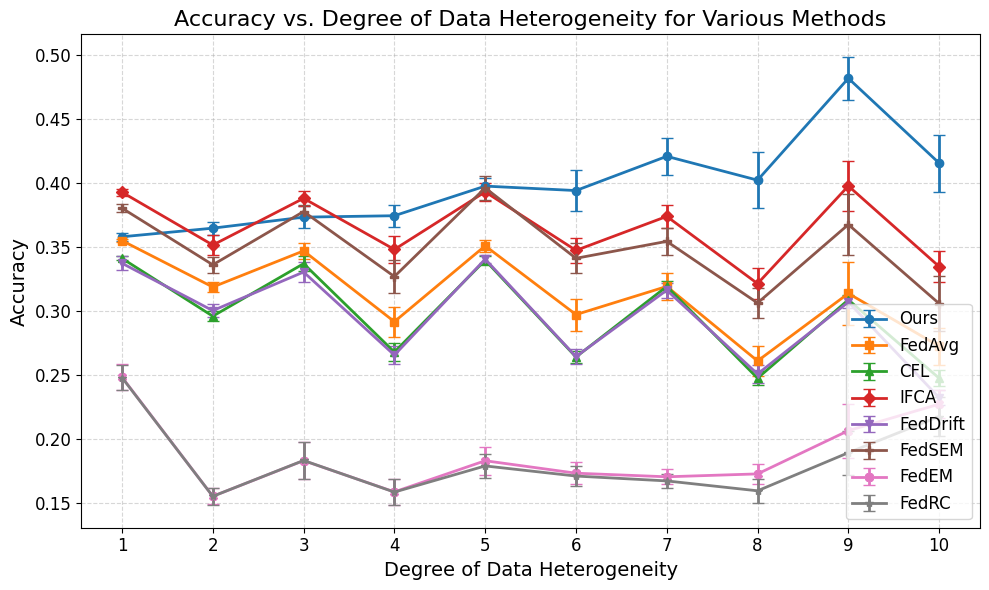

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the degree of heterogeneity (assuming 10 levels)
heterogeneity = np.arange(1, 11)

# Define the data for each method: mean and standard deviation
data = {
    'Ours': {
        'mean': [0.35801, 0.36475137, 0.373368791, 0.374483593, 0.397658824,
                 0.394174326, 0.4209604, 0.402307932, 0.482005443, 0.415653333],
        'std': [0.00707306, 0.011403827, 0.018880244, 0.019281503, 0.014668564,
                0.035386333, 0.032120728, 0.049422077, 0.037698644, 0.049992363]/np.sqrt(5)
    },
    'FedAvg': {
        'mean': [0.355, 0.318698868, 0.346979586, 0.291575819, 0.350928678,
                 0.297122948, 0.319159531, 0.260861883, 0.31366687, 0.272413333],
        'std': [0.001971091, 0.008163456, 0.014371605, 0.026444538, 0.010298767,
                0.028133736, 0.023092988, 0.026577101, 0.05525837, 0.03226028]/np.sqrt(5)
    },
    'CFL': {
        'mean': [0.34112, 0.29587, 0.33697, 0.26781, 0.3397,
                 0.26393, 0.31915, 0.24737, 0.30869, 0.24736],
        'std': [0.003321084, 0.008692626, 0.012948475, 0.016244322, 0.00789282,
                0.010530474, 0.008905578, 0.011952727, 0.007656842, 0.01368715]/np.sqrt(5)
    },
    'IFCA': {
        'mean': [0.39289, 0.351552593, 0.388096119, 0.348083559, 0.39313458,
                 0.347357094, 0.37395786, 0.321369452, 0.397754315, 0.33472],
        'std': [0.006283336, 0.018078136, 0.012840756, 0.023066411, 0.015750668,
                0.022418031, 0.020516203, 0.027437444, 0.04407089, 0.02708588]/np.sqrt(5)
    },
    'FedDrift': {
        'mean': [0.33728, 0.300236667, 0.330425, 0.26544, 0.3405,
                 0.26427, 0.31622, 0.25065, 0.306935, 0.232083333],
        'std': [0.01242858, 0.011482311, 0.017546827, 0.016436735, 0.007511199,
                0.013151794, 0.012910655, 0.015906181, 0.010473461, 0.013322419]/np.sqrt(5)
    },
    'FedSEM': {
        'mean': [0.38041, 0.336072159, 0.37775188, 0.326891486, 0.396221985,
                 0.341168516, 0.354424706, 0.306214873, 0.367593848, 0.30574],
        'std': [0.006549649, 0.014071129, 0.011678362, 0.029022833, 0.020949135,
                0.026336323, 0.023570132, 0.027010207, 0.052587444, 0.048710976]/np.sqrt(5)
    },
    'FedEM': {
        'mean': [0.24814, 0.154948246, 0.182865238, 0.158399132, 0.182772028,
                 0.173029164, 0.170212464, 0.172476694, 0.206324809, 0.227046667],
        'std': [0.022408295, 0.014064061, 0.03221733, 0.023245328, 0.024634191,
                0.018902361, 0.013148686, 0.017713284, 0.047050445, 0.025038519]/np.sqrt(5)
    },
    'FedRC': {
        'mean': [0.24784, 0.154946378, 0.182984079, 0.158247675, 0.178713493,
                 0.170790894, 0.166985326, 0.15924944, 0.189060422, 0.217383184],
        'std': [0.021714562, 0.014471604, 0.032266267, 0.023115451, 0.021571011,
                0.01765251, 0.012040981, 0.021062952, 0.038457726, 0.033743338]/np.sqrt(5)
    }
}

# Define markers and colors for each method for better distinction
markers = {
    'Ours': 'o',
    'FedAvg': 's',
    'CFL': '^',
    'IFCA': 'D',
    'FedDrift': 'v',
    'FedSEM': 'P',
    'FedEM': 'X',
    'FedRC': '*'
}

colors = {
    'Ours': '#1f77b4',
    'FedAvg': '#ff7f0e',
    'CFL': '#2ca02c',
    'IFCA': '#d62728',
    'FedDrift': '#9467bd',
    'FedSEM': '#8c564b',
    'FedEM': '#e377c2',
    'FedRC': '#7f7f7f'
}

# Create the plot
plt.figure(figsize=(10, 6))

for method, stats in data.items():
    plt.errorbar(
        heterogeneity,
        stats['mean'],
        yerr=stats['std'],
        label=method,
        marker=markers.get(method, 'o'),
        color=colors.get(method, None),
        linestyle='-',
        linewidth=2,
        markersize=6,
        capsize=4
    )

# Customize the plot
plt.xlabel('Degree of Data Heterogeneity', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Degree of Data Heterogeneity for Various Methods', fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(heterogeneity, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('accuracy_vs_heterogeneity.png', dpi=300)
plt.savefig('accuracy_vs_heterogeneity.pdf')  # Save as PDF for vector quality
plt.show()

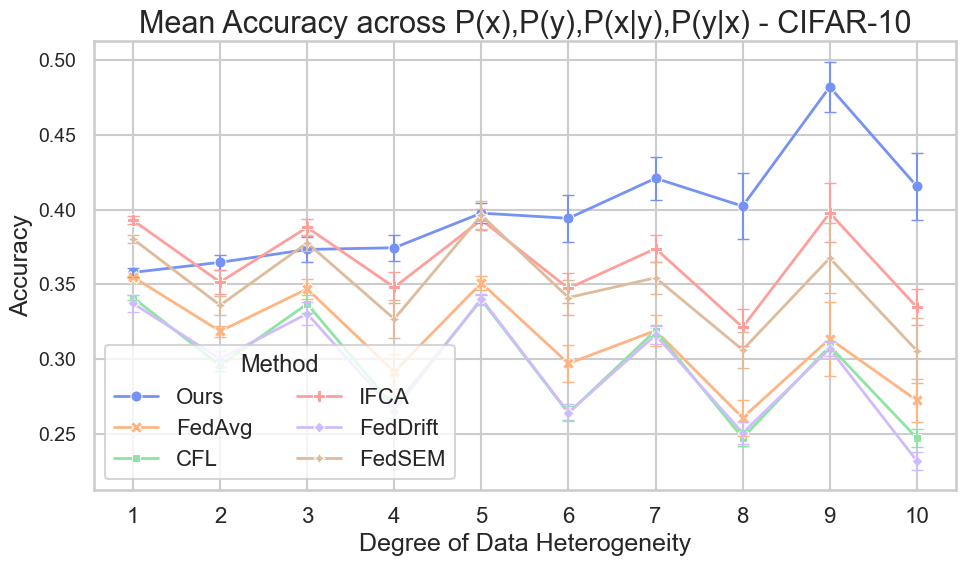

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define the degree of heterogeneity (assuming 10 levels)
heterogeneity = np.arange(1, 11)

# Define the data for each method: mean and standard error (std / sqrt(n))
data = {
    'Method': [],
    'Heterogeneity': [],
    'Mean Accuracy': [],
    'Std Error': []
}

# Number of runs for standard error calculation
n_runs = 5

# Populate the data dictionary
methods = {
    'Ours': {
        'mean': [0.35801, 0.36475137, 0.373368791, 0.374483593, 0.397658824,
                 0.394174326, 0.4209604, 0.402307932, 0.482005443, 0.415653333],
        'std': [0.00707306, 0.011403827, 0.018880244, 0.019281503, 0.014668564,
                0.035386333, 0.032120728, 0.049422077, 0.037698644, 0.049992363]
    },
    'FedAvg': {
        'mean': [0.355, 0.318698868, 0.346979586, 0.291575819, 0.350928678,
                 0.297122948, 0.319159531, 0.260861883, 0.31366687, 0.272413333],
        'std': [0.001971091, 0.008163456, 0.014371605, 0.026444538, 0.010298767,
                0.028133736, 0.023092988, 0.026577101, 0.05525837, 0.03226028]
    },
    'CFL': {
        'mean': [0.34112, 0.29587, 0.33697, 0.26781, 0.3397,
                 0.26393, 0.31915, 0.24737, 0.30869, 0.24736],
        'std': [0.003321084, 0.008692626, 0.012948475, 0.016244322, 0.00789282,
                0.010530474, 0.008905578, 0.011952727, 0.007656842, 0.01368715]
    },
    'IFCA': {
        'mean': [0.39289, 0.351552593, 0.388096119, 0.348083559, 0.39313458,
                 0.347357094, 0.37395786, 0.321369452, 0.397754315, 0.33472],
        'std': [0.006283336, 0.018078136, 0.012840756, 0.023066411, 0.015750668,
                0.022418031, 0.020516203, 0.027437444, 0.04407089, 0.02708588]
    },
    'FedDrift': {
        'mean': [0.33728, 0.300236667, 0.330425, 0.26544, 0.3405,
                 0.26427, 0.31622, 0.25065, 0.306935, 0.232083333],
        'std': [0.01242858, 0.011482311, 0.017546827, 0.016436735, 0.007511199,
                0.013151794, 0.012910655, 0.015906181, 0.010473461, 0.013322419]
    },
    'FedSEM': {
        'mean': [0.38041, 0.336072159, 0.37775188, 0.326891486, 0.396221985,
                 0.341168516, 0.354424706, 0.306214873, 0.367593848, 0.30574],
        'std': [0.006549649, 0.014071129, 0.011678362, 0.029022833, 0.020949135,
                0.026336323, 0.023570132, 0.027010207, 0.052587444, 0.048710976]
    },
    # 'FedEM': {
    #     'mean': [0.24814, 0.154948246, 0.182865238, 0.158399132, 0.182772028,
    #              0.173029164, 0.170212464, 0.172476694, 0.206324809, 0.227046667],
    #     'std': [0.022408295, 0.014064061, 0.03221733, 0.023245328, 0.024634191,
    #             0.018902361, 0.013148686, 0.017713284, 0.047050445, 0.025038519]
    # },
    # 'FedRC': {
    #     'mean': [0.24784, 0.154946378, 0.182984079, 0.158247675, 0.178713493,
    #              0.170790894, 0.166985326, 0.15924944, 0.189060422, 0.217383184],
    #     'std': [0.021714562, 0.014471604, 0.032266267, 0.023115451, 0.021571011,
    #             0.01765251, 0.012040981, 0.021062952, 0.038457726, 0.033743338]
    # }
}

for method, values in methods.items():
    for i in range(len(heterogeneity)):
        data['Method'].append(method)
        data['Heterogeneity'].append(heterogeneity[i])
        data['Mean Accuracy'].append(values['mean'][i])
        data['Std Error'].append(values['std'][i] / np.sqrt(n_runs))

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Define markers and colors for each method for better distinction
markers = {
    'Ours': 'o',
    'FedAvg': 's',
    'CFL': '^',
    'IFCA': 'D',
    'FedDrift': 'v',
    'FedSEM': 'P',
    'FedEM': 'X',
    'FedRC': '*'
}

palette = {
    'Ours': '#1f77b4',
    'FedAvg': '#ff7f0e',
    'CFL': '#2ca02c',
    'IFCA': '#d62728',
    'FedDrift': '#9467bd',
    'FedSEM': '#8c564b',
    'FedEM': '#e377c2',
    'FedRC': '#7f7f7f'
}

# Number of unique methods
n_methods = len(methods)

# Generate a pastel palette with enough colors
pastel_palette = sns.color_palette("pastel", n_colors=n_methods)

# Map methods to colors
palette = dict(zip(methods.keys(), pastel_palette))

# palette = {'Ours': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
#  'FedAvg': (1.0, 0.7058823529411765, 0.5098039215686274),
#  'CFL': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
#  'IFCA': (1.0, 0.6235294117647059, 0.6078431372549019),
#  'FedDrift': (0.8156862745098039, 0.7333333333333333, 1.0),
#  'FedSEM': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019)}

palette['Ours'] = "#91B5F4"  # Slightly darker blue
palette['Ours'] = "#82A2F3"  # More dark blue
palette['Ours'] = "#7592F4"  # Even darker blue
# First Adjustment: #A1C9F4 -> #91B5F4
# Second Adjustment: #91B5F4 -> #82A2F3 (even darker)

# Set Seaborn theme for better aesthetics
sns.set(style="whitegrid", context="talk", palette="deep")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the lineplot with error bars
sns.lineplot(
    data=df,
    x='Heterogeneity',
    y='Mean Accuracy',
    hue='Method',
    marker='o',
    dashes=False,
    markers=True,
    style='Method',
    palette=palette,
    markersize=8,
    linewidth=2,
    # ci=None  # We'll add error bars manually
    
)

# Add error bars manually
for method in methods.keys():
    subset = df[df['Method'] == method]
    plt.errorbar(
        subset['Heterogeneity'],
        subset['Mean Accuracy'],
        yerr=subset['Std Error'],
        fmt='none',
        ecolor=palette[method],
        elinewidth=1.5,
        capsize=4
    )

# Customize the plot
plt.xlabel('Degree of Data Heterogeneity', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('Mean Accuracy across P(x),P(y),P(x|y),P(y|x) - CIFAR-10', fontsize=22)
plt.legend(title='Method', fontsize=16, title_fontsize=17, loc='lower left', ncol=2)
plt.xticks(heterogeneity, fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig('accuracy_vs_heterogeneity_seaborn.png', dpi=300)
plt.savefig('accuracy_vs_heterogeneity_seaborn.pdf')  # Save as PDF for vector quality
plt.show()

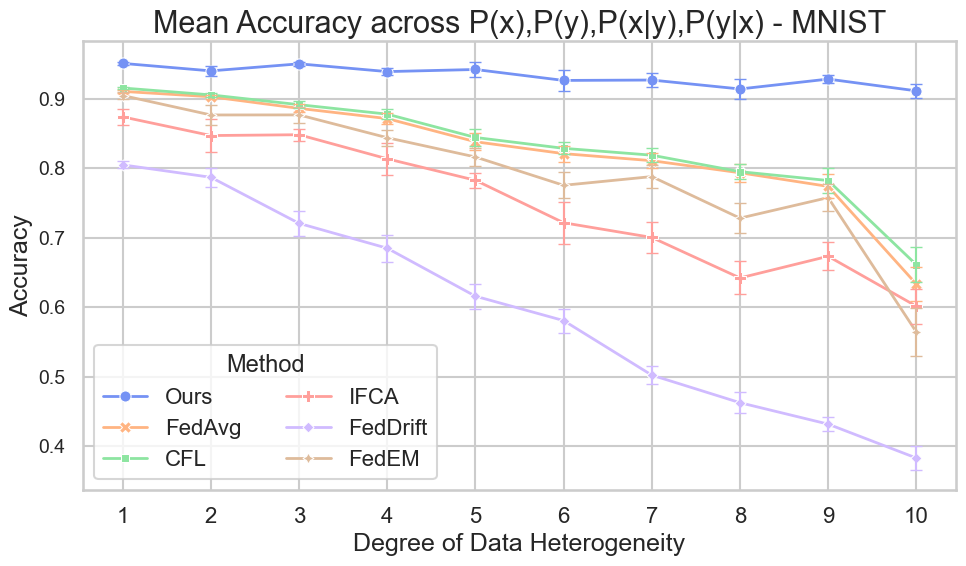

In [24]:
methods = {
    'Ours': {
        'mean': [
            0.95095,
            0.940158386,
            0.950314394,
            0.939123761,
            0.942163027,
            0.926427576,
            0.926987042,
            0.914137247,
            0.928354152,
            0.911426667
        ],
        'std': [
            0.003993134,
            0.016662841,
            0.006736172,
            0.012395725,
            0.022784751,
            0.03370311,
            0.02267323,
            0.031490828,
            0.012342542,
            0.022503782
        ]
    },
    'FedAvg': {
        'mean': [
            0.91067,
            0.90293921,
            0.886229798,
            0.871521212,
            0.838219805,
            0.821110858,
            0.81094743,
            0.793598033,
            0.773947942,
            0.633473333
        ],
        'std': [
            0.004571376,
            0.006762412,
            0.012983104,
            0.01787768,
            0.026973293,
            0.025625136,
            0.023429004,
            0.02816297,
            0.038565226,
            0.053788031
        ]
    },
    'CFL': {
        'mean': [
            0.91554,
            0.905603466,
            0.891523787,
            0.87792378,
            0.844360895,
            0.828748023,
            0.818885207,
            0.79515409,
            0.782421695,
            0.66124478
        ],
        'std': [
            0.003007857,
            0.00603765,
            0.011369661,
            0.015407333,
            0.026309256,
            0.01965496,
            0.022545248,
            0.024413835,
            0.041730503,
            0.05659106
        ]
    },
    'IFCA': {
        'mean': [
            0.87399,
            0.847126603,
            0.84831353,
            0.813658236,
            0.782775077,
            0.721666685,
            0.700513834,
            0.642242196,
            0.673437846,
            0.601626308
        ],
        'std': [
            0.02534074,
            0.053540219,
            0.019900103,
            0.052349401,
            0.023539293,
            0.067015265,
            0.048469151,
            0.053106734,
            0.044791017,
            0.056817554
        ]
    },
    'FedDrift': {
        'mean': [
            0.804955,
            0.787043998,
            0.720793551,
            0.685005895,
            0.615990565,
            0.580900399,
            0.502445581,
            0.462777345,
            0.431945104,
            0.383195666
        ],
        'std': [
            0.010922363,
            0.031071614,
            0.039446111,
            0.043041911,
            0.039722502,
            0.038704586,
            0.028069187,
            0.033349493,
            0.023629448,
            0.037568485
        ]
    },
    'FedEM': {
        'mean': [
            0.90472,
            0.876737898,
            0.876827848,
            0.844011409,
            0.816294333,
            0.775545922,
            0.788076471,
            0.728307223,
            0.757832161,
            0.56448
        ],
        'std': [
            0.012773178,
            0.032190046,
            0.025267584,
            0.025946849,
            0.028222457,
            0.041648221,
            0.036068983,
            0.048773496,
            0.042224882,
            0.077702096
        ]
    }
}



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define the degree of heterogeneity (assuming 10 levels)
heterogeneity = np.arange(1, 11)

# Define the data for each method: mean and standard error (std / sqrt(n))
data = {
    'Method': [],
    'Heterogeneity': [],
    'Mean Accuracy': [],
    'Std Error': []
}

# Number of runs for standard error calculation
n_runs = 5

# Populate the data dictionary


for method, values in methods.items():
    for i in range(len(heterogeneity)):
        data['Method'].append(method)
        data['Heterogeneity'].append(heterogeneity[i])
        data['Mean Accuracy'].append(values['mean'][i])
        data['Std Error'].append(values['std'][i] / np.sqrt(n_runs))

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Define markers and colors for each method for better distinction
markers = {
    'Ours': 'o',
    'FedAvg': 's',
    'CFL': '^',
    'IFCA': 'D',
    'FedDrift': 'v',
    'FedSEM': 'P',
    'FedEM': 'X',
    'FedRC': '*'
}

palette = {
    'Ours': '#1f77b4',
    'FedAvg': '#ff7f0e',
    'CFL': '#2ca02c',
    'IFCA': '#d62728',
    'FedDrift': '#9467bd',
    'FedSEM': '#8c564b',
    'FedEM': '#e377c2',
    'FedRC': '#7f7f7f'
}

# Number of unique methods
n_methods = len(methods)

# Generate a pastel palette with enough colors
pastel_palette = sns.color_palette("pastel", n_colors=n_methods)

# Map methods to colors
palette = dict(zip(methods.keys(), pastel_palette))

# palette = {'Ours': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
#  'FedAvg': (1.0, 0.7058823529411765, 0.5098039215686274),
#  'CFL': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
#  'IFCA': (1.0, 0.6235294117647059, 0.6078431372549019),
#  'FedDrift': (0.8156862745098039, 0.7333333333333333, 1.0),
#  'FedSEM': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019)}

palette['Ours'] = "#91B5F4"  # Slightly darker blue
palette['Ours'] = "#82A2F3"  # More dark blue
palette['Ours'] = "#7592F4"  # Even darker blue
# First Adjustment: #A1C9F4 -> #91B5F4
# Second Adjustment: #91B5F4 -> #82A2F3 (even darker)

# Set Seaborn theme for better aesthetics
sns.set(style="whitegrid", context="talk", palette="deep")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the lineplot with error bars
sns.lineplot(
    data=df,
    x='Heterogeneity',
    y='Mean Accuracy',
    hue='Method',
    marker='o',
    dashes=False,
    markers=True,
    style='Method',
    palette=palette,
    markersize=8,
    linewidth=2,
    # ci=None  # We'll add error bars manually
    
)

# Add error bars manually
for method in methods.keys():
    subset = df[df['Method'] == method]
    plt.errorbar(
        subset['Heterogeneity'],
        subset['Mean Accuracy'],
        yerr=subset['Std Error'],
        fmt='none',
        ecolor=palette[method],
        elinewidth=1.5,
        capsize=4
    )

# Customize the plot
plt.xlabel('Degree of Data Heterogeneity', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('Mean Accuracy across P(x),P(y),P(x|y),P(y|x) - MNIST', fontsize=22)
plt.legend(title='Method', fontsize=16, title_fontsize=17, loc='lower left', ncol=2)
plt.xticks(heterogeneity, fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig('accuracy_vs_heterogeneity_seaborn.png', dpi=300)
plt.savefig('accuracy_vs_heterogeneity_seaborn.pdf')  # Save as PDF for vector quality
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define the degree of heterogeneity (assuming 10 levels)
heterogeneity = np.arange(1, 11)

# Define the data for each method: mean and standard error (std / sqrt(n))
data = {
    'Method': [],
    'Heterogeneity': [],
    'Mean Accuracy': [],
    'Std Error': []
}

# Number of runs for standard error calculation
n_runs = 5

# Populate the data dictionary
methods = {
    'Ours': {
        'mean': [0.35801, 0.36475137, 0.373368791, 0.374483593, 0.397658824,
                 0.394174326, 0.4209604, 0.402307932, 0.482005443, 0.415653333],
        'std': [0.00707306, 0.011403827, 0.018880244, 0.019281503, 0.014668564,
                0.035386333, 0.032120728, 0.049422077, 0.037698644, 0.049992363]
    },
    'FedAvg': {
        'mean': [0.355, 0.318698868, 0.346979586, 0.291575819, 0.350928678,
                 0.297122948, 0.319159531, 0.260861883, 0.31366687, 0.272413333],
        'std': [0.001971091, 0.008163456, 0.014371605, 0.026444538, 0.010298767,
                0.028133736, 0.023092988, 0.026577101, 0.05525837, 0.03226028]
    },
    'CFL': {
        'mean': [0.34112, 0.29587, 0.33697, 0.26781, 0.3397,
                 0.26393, 0.31915, 0.24737, 0.30869, 0.24736],
        'std': [0.003321084, 0.008692626, 0.012948475, 0.016244322, 0.00789282,
                0.010530474, 0.008905578, 0.011952727, 0.007656842, 0.01368715]
    },
    'IFCA': {
        'mean': [0.39289, 0.351552593, 0.388096119, 0.348083559, 0.39313458,
                 0.347357094, 0.37395786, 0.321369452, 0.397754315, 0.33472],
        'std': [0.006283336, 0.018078136, 0.012840756, 0.023066411, 0.015750668,
                0.022418031, 0.020516203, 0.027437444, 0.04407089, 0.02708588]
    },
    'FedDrift': {
        'mean': [0.33728, 0.300236667, 0.330425, 0.26544, 0.3405,
                 0.26427, 0.31622, 0.25065, 0.306935, 0.232083333],
        'std': [0.01242858, 0.011482311, 0.017546827, 0.016436735, 0.007511199,
                0.013151794, 0.012910655, 0.015906181, 0.010473461, 0.013322419]
    },
    'FedSEM': {
        'mean': [0.38041, 0.336072159, 0.37775188, 0.326891486, 0.396221985,
                 0.341168516, 0.354424706, 0.306214873, 0.367593848, 0.30574],
        'std': [0.006549649, 0.014071129, 0.011678362, 0.029022833, 0.020949135,
                0.026336323, 0.023570132, 0.027010207, 0.052587444, 0.048710976]
    },
    'FedEM': {
        'mean': [0.24814, 0.154948246, 0.182865238, 0.158399132, 0.182772028,
                 0.173029164, 0.170212464, 0.172476694, 0.206324809, 0.227046667],
        'std': [0.022408295, 0.014064061, 0.03221733, 0.023245328, 0.024634191,
                0.018902361, 0.013148686, 0.017713284, 0.047050445, 0.025038519]
    },
    'FedRC': {
        'mean': [0.24784, 0.154946378, 0.182984079, 0.158247675, 0.178713493,
                 0.170790894, 0.166985326, 0.15924944, 0.189060422, 0.217383184],
        'std': [0.021714562, 0.014471604, 0.032266267, 0.023115451, 0.021571011,
                0.01765251, 0.012040981, 0.021062952, 0.038457726, 0.033743338]
    }
}

for method, values in methods.items():
    for i in range(len(heterogeneity)):
        data['Method'].append(method)
        data['Heterogeneity'].append(heterogeneity[i])
        data['Mean Accuracy'].append(values['mean'][i])
        data['Std Error'].append(values['std'][i] / np.sqrt(n_runs))

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Define markers and colors for each method for better distinction
markers = {
    'Ours': 'o',
    'FedAvg': 's',
    'CFL': '^',
    'IFCA': 'D',
    'FedDrift': 'v',
    'FedSEM': 'P',
    'FedEM': 'X',
    'FedRC': '*'
}

palette = {
    'Ours': '#1f77b4',
    'FedAvg': '#ff7f0e',
    'CFL': '#2ca02c',
    'IFCA': '#d62728',
    'FedDrift': '#9467bd',
    'FedSEM': '#8c564b',
    'FedEM': '#e377c2',
    'FedRC': '#7f7f7f'
}

# Customize Seaborn theme with lighter grid
sns.set_style("whitegrid", {
    "grid.linestyle": "--",
    "grid.color": ".8",       # Light gray grid lines
    "grid.linewidth": 0.5,    # Thinner grid lines
    "axes.edgecolor": ".15"
})
sns.set_context("talk", font_scale=1.2)
sns.set_palette(palette)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the lineplot with error bars
sns.lineplot(
    data=df,
    x='Heterogeneity',
    y='Mean Accuracy',
    hue='Method',
    marker='o',
    dashes=False,
    markers=True,
    style='Method',
    palette=palette,
    markersize=8,
    linewidth=2,
    ci=None  # We'll add error bars manually
)

# Add error bars manually
for method in methods.keys():
    subset = df[df['Method'] == method]
    plt.errorbar(
        subset['Heterogeneity'],
        subset['Mean Accuracy'],
        yerr=subset['Std Error'],
        fmt='none',
        ecolor=palette[method],
        elinewidth=1.5,
        capsize=4
    )

# Customize the plot
plt.xlabel('Degree of Data Heterogeneity', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Degree of Data Heterogeneity for Various Methods', fontsize=18)
plt.legend(title='Method', fontsize=12, title_fontsize=14, loc='lower right', ncol=2)
plt.xticks(heterogeneity, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig('accuracy_vs_heterogeneity_seaborn.png', dpi=300)
plt.savefig('accuracy_vs_heterogeneity_seaborn.pdf')  # Save as PDF for vector quality
plt.show()

ValueError: Could not generate a palette for <map object at 0x314cf2dd0>

In [3]:
import numpy as np  
from math import prod
import json
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


#############################################################################################################
# Models 
#############################################################################################################
# LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, input_size=(28, 28)):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Convolutional layer with 6 feature maps of size 5x5
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 6 feature maps of size 2x2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Convolutional layer with 16 feature maps of size 5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling layer with 16 feature maps of size 2x2
        
        # Dinamically calculate the size of the features after convolutional layers
        dummy_input = torch.zeros(1, in_channels, *input_size)
        dummy_output = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        self.feature_size = prod(dummy_output.size()[1:])

        self.fc1 = nn.Linear(self.feature_size, 120)  # Fully connected layer, output size 120
        self.fc2 = nn.Linear(120, 84)  # Fully connected layer, output size 84
        self.fc3 = nn.Linear(84, num_classes)  # Fully connected layer, output size num_classes

    def forward(self, x, latent=False):
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(x)  # Apply subsampling pool1
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(x)  # Apply subsampling pool2
        x_l = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x_l))  # Apply ReLU after fc1
        x = F.relu(self.fc2(x))  # Apply ReLU after fc2
        x = self.fc3(x)  # Output layer
        if latent:
            return x, x_l
        else:
            return x

model = LeNet5(in_channels=1, num_classes=10, input_size=(28,28))
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 61706


In [4]:
model = LeNet5(in_channels=3, num_classes=10, input_size=(32,32))
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 83126
